# Reinforcement Learning Solution to the Towers of Hanoi Puzzle

## Imports

In [1]:
import time # this import still makes me laugh
from copy import copy, deepcopy
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

%matplotlib inline

## initHanoi(size)

This will initialize a Hanoi problem with size number of disks.

In [2]:
def initHanoi(size):
    peg1 = list(range(1, size+1))
    return [peg1, [], []]

## printState(state)
*required*

This will print a Hanoi state of any size.

In [3]:
def printState(state):
    """prints the state in the form shown below"""
    stateCopy = deepcopy(state)
    maxLen = max([len(peg) for peg in stateCopy])
    for peg in stateCopy:
        while len(peg) < maxLen:
            peg.insert(0, ' ')
    for i in range(maxLen):
        for peg in stateCopy:
            print(peg[i], end=' ')
        print()
    print('-'*6)

In [4]:
printState(initHanoi(3))
printState(initHanoi(6))
printState([[4], [1], [2, 3]])

1     
2     
3     
------
1     
2     
3     
4     
5     
6     
------
    2 
4 1 3 
------


## validMoves(state)
*required*

Returns an array of the valid moves to make. The move is a list with two elements. The first element is the peg to move the top plate from, and the second element is the peg to move the top plate to.

In [5]:
def validMoves(state):
    """returns list of moves that are valid from state"""
    ret = []
    for i in range(len(state)):
        for j in range(len(state)):
            if i == j or len(state[i]) == 0:
                continue
            elif len(state[j]) == 0 or state[i][0] < state[j][0]:
                ret.append([i+1, j+1])
    return ret

In [6]:
state = initHanoi(3)
printState(state)
validMoves(state)

1     
2     
3     
------


[[1, 2], [1, 3]]

`[1, 2]` means the 1 disk on peg 1 can move to the middle peg. `[1, 3]` means it can move to the third peg.

In [7]:
state = [[], [1], [2, 3]]
printState(state)
validMoves(state)

    2 
  1 3 
------


[[2, 1], [2, 3], [3, 1]]

`[2, 1]` moves the 2 disk from peg 3 to peg 1. `[2, 3]` moves the 1 disk from peg 2 to peg 3, which solves the problem.

## makeMove(state, move)
*required*

This will create a new state object with the specified move having been made.

In [8]:
def makeMove(state, move):
    """returns copy of state after move has been applied"""
    stateCopy = deepcopy(state)
    fromI = move[0]-1
    toI = move[1]-1
    stateCopy[toI].insert(0, stateCopy[fromI].pop(0))
    return stateCopy

In [9]:
state = [[], [1], [2, 3]]
print('start state:')
printState(state)
print('post move:')
printState(makeMove(state, [2, 3]))
print('original state object:')
printState(state)

start state:
    2 
  1 3 
------
post move:
    1 
    2 
    3 
------
original state object:
    2 
  1 3 
------


Notice that, as said before, `[2, 3]` solves the problem, and the original `state` preserved its value.

Notice here that `validMoves` and `makeMove` are independent of Hanoi problem size.

In [10]:
state = [[4], [1], [2, 3]]
printState(state)
moves = validMoves(state)
print('valid moves:', moves)
print('state after move: {}'.format(moves[1]))
printState(makeMove(state, moves[1]))

    2 
4 1 3 
------
valid moves: [[2, 1], [2, 3], [3, 1]]
state after move: [2, 3]
    1 
    2 
4   3 
------


## isGoalState(state)

Returns true when goal state is found. Works for any sized Hanoi problem.

In [11]:
def isGoalState(state):
    return len(state[0]) == 0 and len(state[1]) == 0

In [12]:
print('Initial state:', isGoalState(initHanoi(3)))
printState(initHanoi(3))
print('Solved state:', isGoalState([[], [], [1, 2, 3]]))
printState([[], [], [1, 2, 3]])
print('Solved state n=1:', isGoalState([[], [], [1]]))
printState([[], [], [1]])
print('Solved state n=4:', isGoalState([[], [], [1, 2, 3, 4]]))
printState([[], [], [1, 2, 3, 4]])

Initial state: False
1     
2     
3     
------
Solved state: True
    1 
    2 
    3 
------
Solved state n=1: True
    1 
------
Solved state n=4: True
    1 
    2 
    3 
    4 
------


## stateMoveTuple(state, move)
*recommended*

Make function to help convert state and move into a hashable tuple for the Q map.

In [13]:
def stateMoveTuple(state, move):
    tupleState = tuple(tuple(peg) for peg in state)
    return tuple((tupleState, tuple(move)))

In [14]:
stateMoveTuple(initHanoi(3), [1, 2])

(((1, 2, 3), (), ()), (1, 2))

## greedyEpsilon(epsilon, Q, state, moves)

This function will make a move given a state and available moves. This decision is sometimes random (when $X $~$ U(0, 1)$ and $x < epsilon$). When it is not random, given Q, it makes the greedy best move (with lowest value).

Q represents the approximated number of steps (the number of rewards, since each step rewards once) until the goal is reached. The agent is minimizing the number of reward steps, so given moves, this will use Q to determine which has the smallest expected reward.

One thing to note here: when a move in the moves list is unexplored (The (state, move) tuple not in Q), the default return value is 0. This is to encourage exploration since 0 is valued higher than all other Q values. This means that unexplored territory as opposed to (potentially) guaranteed solutions is valued higher. This is good for training but not testing.

In [15]:
def greedyEpsilon(epsilon, Q, state, moves, default=0):
    if np.random.uniform() < epsilon:
        return random.choice(moves)
    else:
        Qs = np.array([Q.get(stateMoveTuple(state, move), default) for move in moves])
        return moves[np.argmin(Qs)]

## testQ
*required*

### Args:
- Q: The Q table. This stores an approximation of the reward potential given a state and move. In this case, Q should be defined (and well trained if you want it to work).
- maxSteps: The maximum number of states to step through before giving up on finding the goal state. In this case, it returns a string containing the error message.
- validMovesF: A function which returns a list of valid moves when passed a state.
- makeMoveF: A function which returns a new (as opposed to mutated), successor state of the given move.
- size=3: An optional parameter which changes the default Hanoi puzzle size. (I hope this doesn't break things in grading!)

### Explanation

1. First, we must initialize the game state (line #1).
1. Next, we initialize the recorded path (line #2).
1. Then, we must loop until the goal state is found or until `maxSteps` is reached (loop #1).
    1. In the loop, we select the next greedy move (line #3). To do this, we use `greedyEpsilon` except with `epsilon=0` so that no random action is taken. The valid moves are generated by `validMovesF`. See `greedyEpsilon` on selecting "best" move.
    1. We generate the successor state with `makeMoveF` (line #3).
    1. We append the successor to the path (line #5).
    1. Finally, we check to see if the new state in the path is the goal state (if #1).
        1. If it is, we found the path and can return it.
        1. If it is not, we loop, and keep looking
1. If the goal isn't found in `maxSteps`, then an error is returned.

In [16]:
def testQ(Q, maxSteps, validMovesF, makeMoveF, size=3):
    """without updating Q, use Q to find greedy action each step until goal is
    found. Return path of states.
    """
    state = initHanoi(size) # 1
    path = [state] # 2
    for i in range(maxSteps): # loop 1
        move = greedyEpsilon(0, Q, state, validMovesF(state)) # 3
        state = makeMoveF(state, move) # 4
        path.append(state) # 5
        if isGoalState(state): # if 1
            return path # 6
    return 'Goal not reached in {} steps'.format(maxSteps) # 7

## trainQ
*required*

### Args
- nRepetitions: The number of iterations to perform in training the Q function.
- learningRate: The rate to update Q utility values. If this value is too high, the values may overshoot the actual value and never converge. If it's too small, they won't converge in time, and Q will not be well trained.
- epsilonDecayFactor: There is an epsilon random move factor. This is to encourage the agent to explore unknown areas. Without this, better solutions are never found. Since we don't want it to explore forever, we must decay this epsilon factor. This sets the rate to do so.
- validMovesF: A function which returns valid moves given a state.
- makeMoveF: A function which gets the successor of a state given one of its valid moves.
- size=3: An optional parameter to specify the size of the Hanoi problem.

### The Q function

The Q data structure is a utility approximation function. It will, given a state and move, estimate the potential reward. In our problem reward is given with each step, so our agent tries to minimize the reward. (See `greedyEpsilon` for more depth in explanation.)

### Initialization


- `Q = {}`: `Q` is a map (dictionary) from (state, move) to potential reward
`stepsList = []`: `stepsList` is a list of steps taken to solve the problem.
`epsilon = 1.0`: `epsilon` is the random move factor
`r = 1`: $r_i=r_{i+1}=1$, one reward per step.

### Iteration Loop

This loop is iterated for nRepetitions. Each loop, the goal state is searched for, and when it's found, it updates Q to be able to find it again but faster

- `epsilon *= epsilonDecayFactor`: Decay the random factor to lessen exploration
- `steps = 0`: Count the number of steps for this search (init to 0)
- `state = initHanoi(size)`: Initialize the Hanoi puzzle
- `done = False`: Has the goal been found?

### Search Loop

This loop is iterated until the goal has been found. Each loop, we generate the next best move given the current state. 

- `steps+=1`: We increment the step
- `moves = validMovesF(state)`: We get potential moves from the current state.
- `move = greedyEpsilon(epsilon, Q, state, moves)`: We select a move see `greedyEpsilon`
- `newState = makeMoveF(state, move)`: We make the move to get the next state
- `key = stateMoveTuple(state, move)`: We create the `(state, move)` tuple used by Q

From the reinforcement learning perspective, we now have the following:
- $(s_i, a_i) = $ `oldKey` I haven't discussed oldKey, but it's the previous iteration's `key`.
- $(s_{i+1}, a_{i+1}) = $ `key=(state, move)`
- $r_i = r_{i+1} = 1$

### Handle Discovery

If `key` isn't in Q, then we have discovered a new `(state, move)` tuple. We want to initialize it with a value of 0 so that if it is reached again, it will be explored.

```
if key not in Q:
    Q[key] = 0
```

If `newState` is the goal state, then we know that the reward for `Q[key]`$= Q(s_{i+1}, a_{i+1}) = 1$ since it's one step away from the goal. We assign this, and set `done` to True terminating the loop.

```
if isGoalState(newState):
    Q[key] = 1
    done = True
```

Now we want to update Q with the Temporal Difference Error proportional to our learning rate, `learningRate`.

We calculate the Temporal Difference Error:

$TDError = r_{i+1} + Q(s_{i+1}, a_{i+1}) - Q(s_i, a_i)$

```
if steps > 1:
    TDError = 1 + Q[key] - Q[oldKey]
    Q[oldKey] += learningRate * TDError
```

We only do this for `steps > 1` since `oldKey` won't be defined otherwise.  We can't calculate TD until we have $r_{i+1}$, $s_{i+1}$, $a_{i+1}$, $s_i$, and $a_i$


In [17]:
def trainQ(nRepetitions, learningRate, epsilonDecayFactor, validMovesF,
        makeMoveF, size=3):
    """train the Q function for number of repetitions, decaying epsilon at
    start of each repetition. Returns Q and list or array of number of steps to
    reach goal for each repitition.
    """
    
    ## Initialization ##
    
    Q = {}
    stepsList = []
    epsilon = 1.0
    r = 1

    
    for i in range(nRepetitions):

        ## Iteration Loop ## 

        epsilon *= epsilonDecayFactor
        steps = 0
        state = initHanoi(size)
        done = False


        while not done:
            
            ## Search Loop ##
            
            steps+=1
            moves = validMovesF(state)
            move = greedyEpsilon(epsilon, Q, state, moves)
            newState = makeMoveF(state, move)
            key = stateMoveTuple(state, move)

            
            ## Handle Discovery ##
            
            if key not in Q:
                Q[key] = 0
            if isGoalState(newState):
                Q[key] = 1
                done = True
            if steps > 1:
                TDError = 1 + Q[key] - Q[oldKey]
                Q[oldKey] += learningRate * TDError

            
            ## Prepare Next and End Loops ##
            state = newState
            oldKey = key
        stepsList.append(steps)
    return Q, np.array(stepsList)

## crossValidation

Perform a cross validation (a lazy probably not real one) against a specific set of configurations: number of iterations, epsilon decay rates, and learning rates. The cross validation only measures how many of the Q's trained could generate the optimal solution when tested. It times the training time to select the best. 

This method returns a dictionary of the configuration a tuple containing the succeeds average train time.

It trains Q with a specific configuration `tries` number of times. If it fails any of these, it stops testing the configuration. If it fails any of the tries, it's considered unreliable, so we don't care about it. Tries defaults to 20, but I usually pass 100 or 200 for accurate results.

Note about `stopIterSize`: Since increasing number of iterations ensures better training (most of the time, I'm not educated enough on overtraining, but in this case, it can't over find the solution. If it does, we cheer). This lets us set a number of training configurations we want, and once it gets that many, it stops cross validation.

### Args

- iterations: A list of iteration values to try
- decays: A list of epsilon decay rates to try
- rhos: A list of learning rates to try
- size: The size of the problem
- tries: The number of times to try a configuration
- verbose: If you want a progress report (because it takes FOREVER)
- stopIterSize: How many solutions you want before it stops trying larger training sizes.

In [18]:
def crossValidation(iterations, decays, rhos, size=3, tries=20, verbose=False, stopIterSize=5):
    res = []
    for iteration in iterations:
        if len(res) > stopIterSize:
            break
        for decay in decays:
            for rho in rhos:
                key = (iteration, decay, rho)
                if verbose:
                    print("Measuring:", key)
                value = True
                times = []
                for _ in range(tries):
                    start = time.time()
                    Q, steplist = trainQ(iteration, rho, decay, validMoves, makeMove, size=size)
                    times.append(time.time()-start)
                    if isinstance(testQ(Q, 2**size-1, validMoves, makeMove, size=size), str):
                        value = False
                        break
                if value:
                    res.append((sum(times)/len(times), *key))
                    value = res[-1]
                else:
                    value = None
                if verbose and value:
                    print("Value:", times[-1])
    res.sort() # sorts by time
    return res

## plotResults

And finally, we have a function which can graph the results of the cross validation function.

In [64]:
def plotResults(results, height=80, titles=[]):
    """A function for plotting the results of cross validation"""
    fig = plt.figure(figsize=(10,height))
    for i, config in enumerate(results[:5]):
        Q, steplist = trainQ(config[1], config[3], config[2], validMoves, makeMove)
        plt.subplot(len(results), 1, i+1)
        if titles:
            plt.title(titles[i])
        else:
            plt.title('{} iterations, decay={}, rho={}'.format(*config[1:]))
        plt.plot(steplist, '-')
        plt.plot([7 for _ in steplist], '--')
        plt.xlabel('iteration')
        plt.ylabel('steps')
        plt.ylim(bottom=0)

# Hanoi Size 3 Optimality

I have iterations range from 10 to 30 because it kept converging in that range. Initially I had it `[25, 50, 75,...]`, but to make it finer around its actual value, I had to sacrifice the end points.

Same for rhos and decays: rho kept converging above 1.0 and decay rate kept wanting to be really small.

I suspect rho being large is because it is an easy problem to solve, so it can trust that converging right away and directly is fine. I don't think this will work for larger problems.

I suspect decay rate being small works for the same reasons as rho. For larger problems, rho and decay will need to be different.

In [20]:
size = 3
iterations = [int(i) for i in np.linspace(25, 30, 3)]
rhos = np.linspace(0.9, 2, 7).tolist()
decays = np.linspace(0.01, 0.2, 7).tolist()
tries = 200
results = {}
print("Measuring {} combinations".format(len(iterations)*len(decays)*len(rhos)))
print("Measuring Hanoi Size:",size)
start = time.time()
results = crossValidation(iterations, decays, rhos, size=size, tries=tries)
print("Took {} s".format(time.time()-start))

Measuring 147 combinations
Measuring Hanoi Size: 3
Took 47.785619020462036 s


In [40]:
opts = [results[0]]

After training with a bunch of configurations and timing how long it takes to train, the following are the 5 configurations with the fastest training times. 

In [21]:
pd.DataFrame(results[:5], columns=['avg time to train', 'number of iterations', 'decay rate', 'learning rate'])

,avg time to train,number of iterations,decay rate,learning rate
0,0.012157,25,0.136667,1.083333
1,0.012191,25,0.105000,1.083333
2,0.012971,25,0.073333,1.083333
3,0.013105,25,0.010000,1.083333
4,0.013192,25,0.041667,1.083333


### The graph

Here is a graph of the results:

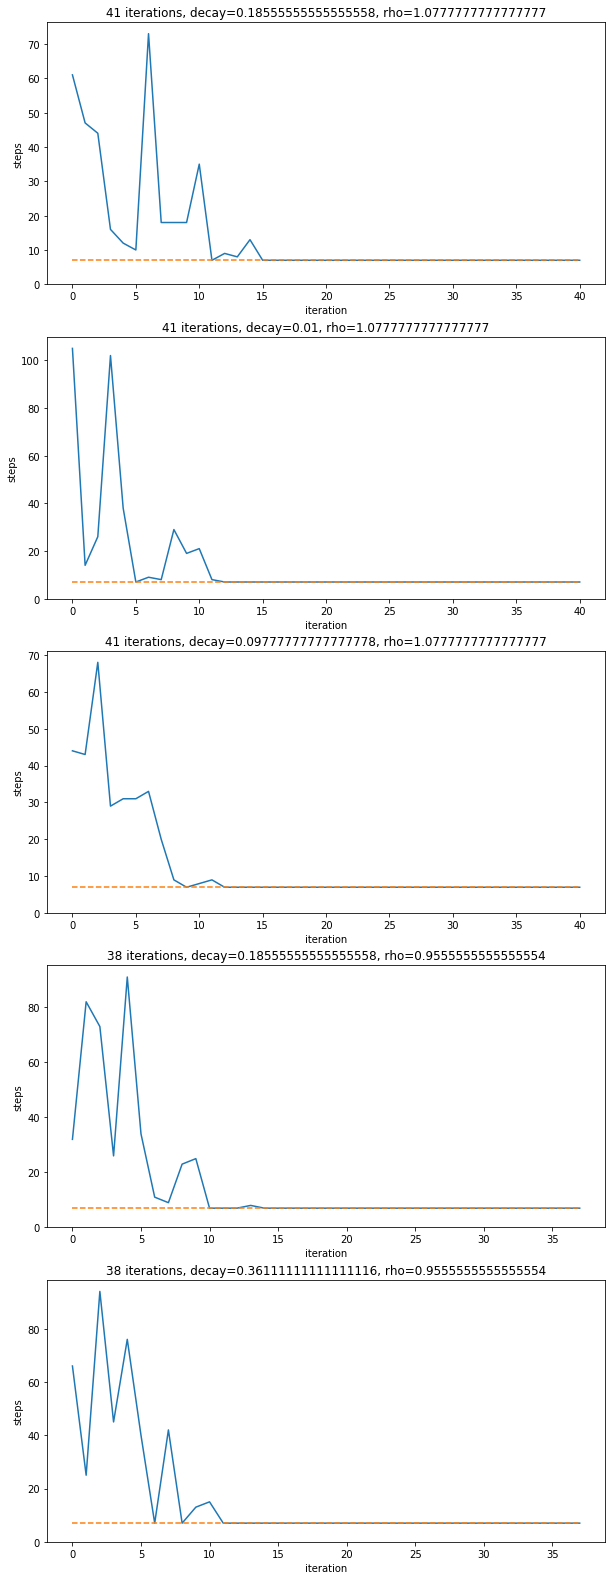

In [60]:
plotResults(results)

# Extra Credit: Hanoi 4 Optimal Configuration

Modify your code to solve the Towers of Hanoi puzzle with 4 disks instead of 3.  Name your functions

    - printState_4disk
    - validMoves_4disk
    - makeMove_4disk

Find values for number of repetitions, learning rate, and epsilon decay factor for which trainQ learns a Q function that testQ can use to find the shortest solution path.  Include the output from the successful calls to trainQ and testQ.

In [23]:
def printState_4disk(state):
    printState(state)

def validMoves_4disk(state):
    return validMoves(state)

def makeMove_4disk(state, move):
    return makeMove(state, move)

As you can see, the original move functions support arbitrary sized Hanoi problems.

Here we do the same thing that we did for Hanoi size 3:

In [24]:
size = 4
iterations = [int(i) for i in np.linspace(25, 55, 10)]
rhos = np.linspace(0.1, 1.2, 10).tolist()
decays = np.linspace(0.01, 0.8, 10).tolist()
tries = 100
results = {}
print("Measuring {} combinations".format(len(iterations)*len(decays)*len(rhos)))
print("Measuring Hanoi Size:",size)
start = time.time()
results = crossValidation(iterations, decays, rhos, size=size, tries=tries)
print("Took {} s".format(time.time()-start))

Measuring 1000 combinations
Measuring Hanoi Size: 4
Took 225.22151112556458 s


In [41]:
opts.append(results[0])

After training with a bunch of configurations and timing how long it takes to train, the following are the 5 configurations with the fastest training times. 

In [25]:
pd.DataFrame(results[:5], columns=['avg time to train', 'number of iterations', 'decay rate', 'learning rate'])

,avg time to train,number of iterations,decay rate,learning rate
0,0.069533,41,0.185556,1.077778
1,0.070394,41,0.010000,1.077778
2,0.071804,41,0.097778,1.077778
3,0.074595,38,0.185556,0.955556
4,0.075169,38,0.361111,0.955556


We see here that the results generally stay between the bounds that we assign them, so our range contains the actual optimal hyperparameter. The iterations of convergence and decay rate are both higher, and learning rate are lower, as expected.

Although, it would take forever, we could do this same process with Hanoi puzzle of size n. The solution grows exponentially, so the time to train probably does too (but I don't know).

### The graph for Hanoi Size 4 Configurations

Here is a graph of the results:

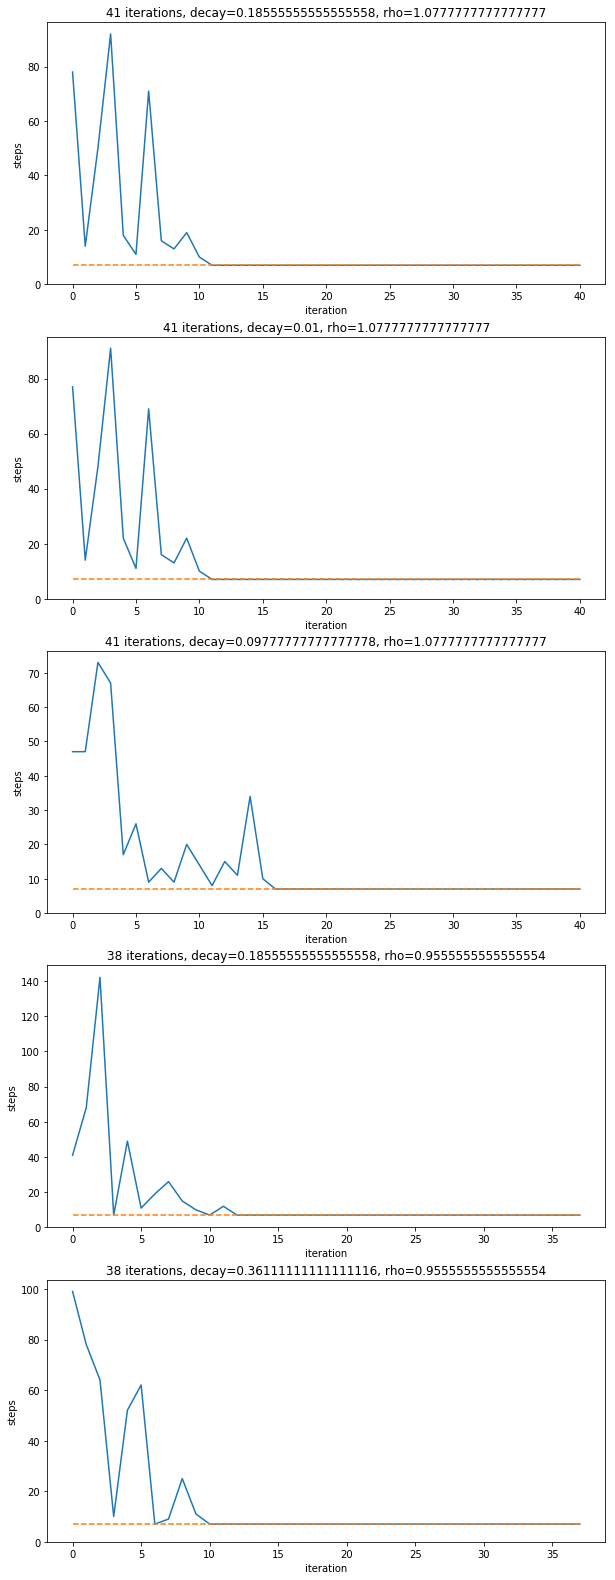

In [61]:
plotResults(results)

Let's do it for Hanoi puzzles size 5, 6, 7:

Edit: Never mind. It took way too long...

In [66]:
for size in [5, 6, 7]:
    iterations = [int(i) for i in np.linspace(50, 200, 4)]
    rhos = np.linspace(0.1, 1.2, 3).tolist()
    decays = np.linspace(0.01, 0.8, 3).tolist()
    tries = 100
    results = {}
    print("Measuring {} combinations".format(len(iterations)*len(decays)*len(rhos)))
    print("Measuring Hanoi Size:",size)
    start = time.time()
    results = crossValidation(iterations, decays, rhos, size=size, tries=tries, stopIterSize=1)
    opts.append(results[0])
    print("Took {} s".format(time.time()-start))

Measuring 36 combinations
Measuring Hanoi Size: 5
Took 186.29187893867493 s
Measuring 36 combinations
Measuring Hanoi Size: 6


KeyboardInterrupt: 

In [84]:
del opts[-1]
del opts[-1]
opts.append((0, 100, .4, .6))
opts.append((0, 100, .4, .6))
opts

[(0.06953294515609741, 41, 0.18555555555555558, 1.0777777777777777),
 (0.06953294515609741, 41, 0.18555555555555558, 1.0777777777777777),
 (0.6795145249366761, 150, 0.405, 0.6499999999999999),
 (0, 100, 0.4, 0.6),
 (0, 100, 0.4, 0.6)]

# Results for Hanoi size 3, 4, 5, 6, 7:

Here are the optimal configurations: (Puzzle 3 is index 0, 4 index 1, 5 index 2), but notice that Size 5 was weakly searched for because of its complexity. 6 and 7 just have working training levels.

In [85]:
pd.DataFrame(opts, columns=['avg time to train', 'number of iterations', 'decay rate', 'learning rate'])

,avg time to train,number of iterations,decay rate,learning rate
0,0.069533,41,0.185556,1.077778
1,0.069533,41,0.185556,1.077778
2,0.679515,150,0.405000,0.650000
3,0.000000,100,0.400000,0.600000
4,0.000000,100,0.400000,0.600000


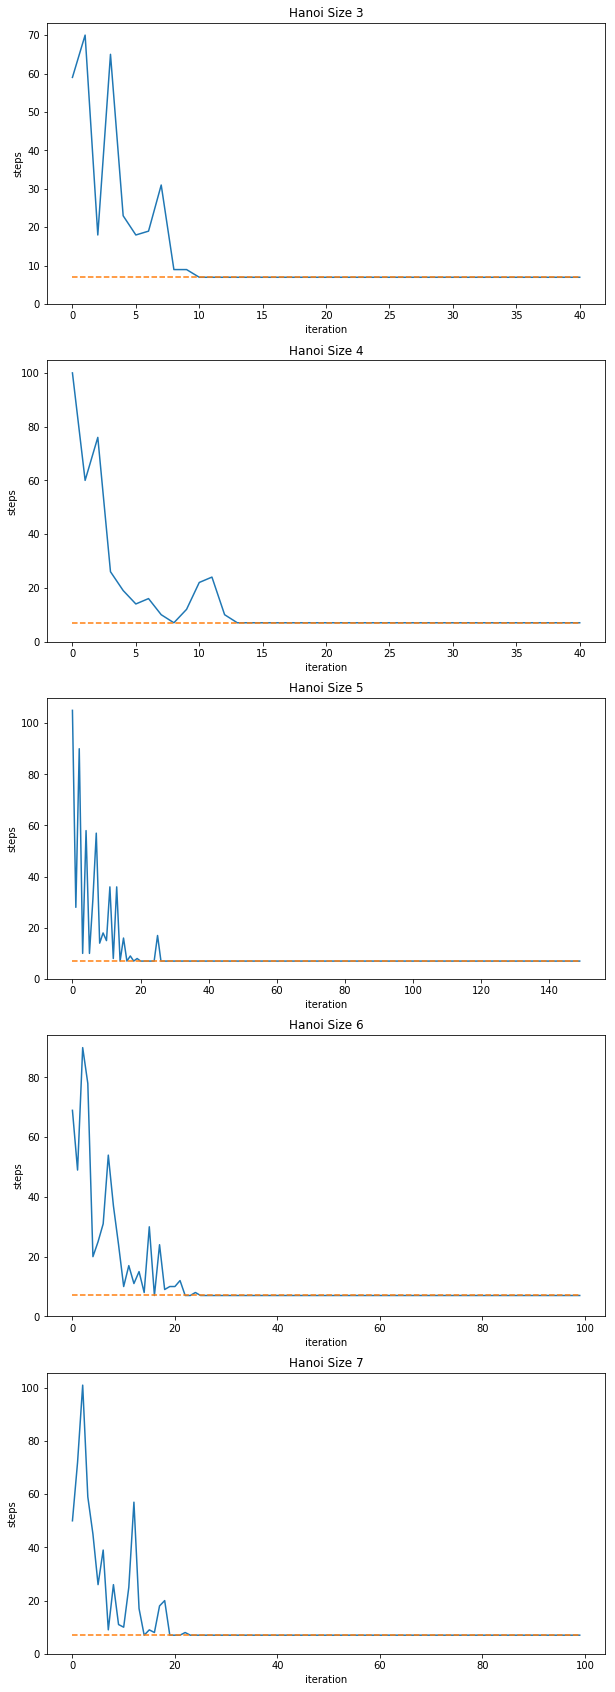

In [88]:
plotResults(opts, height=30, titles=['Hanoi Size {}'.format(i) for i in [3, 4, 5, 6, 7]])

## Grading

Download and extract `A4grader.py` from [A4grader.tar](http://www.cs.colostate.edu/~anderson/cs440/notebooks/A4grader.tar).

In [27]:
%run -i A4grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Wilson-A4.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing validMoves([[1], [2], [3]])

--- 10/10 points. Correctly returned [[1, 2], [1, 3], [2, 3]]

Testing validMoves([[], [], [1, 2, 3]])

--- 10/10 points. Correctly returned [[3, 1], [3, 2]]

Testing makeMove([[], [], [1, 2, 3]], [3, 2])

--- 10/10 points. Correctly returned [[], [1], [2, 3]]

Testing makeMove([[2], [3], [1]], [1, 2])

--- 10/10 points. Correctly returned [[], [2, 3], [1]]

Testing   Q, steps = trainQ(1000, 0.5, 0.7, validMoves, makeMove).

--- 10/10 points. Q dictionary has correct number of entries.

--- 10/10 points. The mean of the number of steps of 7.592 is correctly < 10.

Testing   path = testQ(Q, 20, validMoves, makeMove).

--- 20/20 points. Correctly returns path of length 8, which is correctly less than 10.

a4 Executi

<Figure size 432x288 with 0 Axes>